The idea is to experiment different regression models such as lm, lasso, rf, etc along with the caret preprocess function. 
The database contains observations of weights and diameters of peaches.
The "true" relationship is a cubic function Weight=pulpDensity*(constant*(D)^3) + seedWeight.

Peach weight is the response variable.

# Data wrangling

In [1]:
library(tidyverse, warn.conflicts = F, quietly = T)
library(caret, warn.conflicts = F, quietly = T)
library(doParallel, warn.conflicts = F, quietly = T)
library(drc, warn.conflicts = F, quietly = T)
library(dbscan, warn.conflicts = F, quietly = T)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



'drc' has been loaded.


Please cite R and 'drc' if used for a publication,

for references type 'citation()' and 'citation('drc')'.




In [2]:
Data<-read_csv("duraznosfinal.csv")

New names:
* `` -> ...1

Rows: 1186 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (6): ...1, Zona, Finca, Peso, Diámetro Sutural, Diámetro Contrasutural

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
str(Data)

spec_tbl_df [1,186 × 6] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ ...1                  : num [1:1186] 1 2 3 4 5 6 7 8 9 10 ...
 $ Zona                  : num [1:1186] 1 1 1 1 1 1 1 1 1 1 ...
 $ Finca                 : num [1:1186] 301 1502 301 301 1502 ...
 $ Peso                  : num [1:1186] 147 87 139 159 128 83 94 129 105 125 ...
 $ Diámetro Sutural      : num [1:1186] 64 57 65 69 64 56 57 63.7 60 63 ...
 $ Diámetro Contrasutural: num [1:1186] 67 53 64 67 62 52 55 62.1 59 61 ...
 - attr(*, "spec")=
  .. cols(
  ..   ...1 = col_double(),
  ..   Zona = col_double(),
  ..   Finca = col_double(),
  ..   Peso = col_double(),
  ..   `Diámetro Sutural` = col_double(),
  ..   `Diámetro Contrasutural` = col_double()
  .. )
 - attr(*, "problems")=<externalptr> 


In [4]:
Data$`...1`<-NULL
Data$Zona<-as.factor(Data$Zona)
Data$Finca<-as.factor(Data$Finca)
Data<-rename(Data,"DS"="Diámetro Sutural");
Data<-rename(Data,"DCS"="Diámetro Contrasutural");

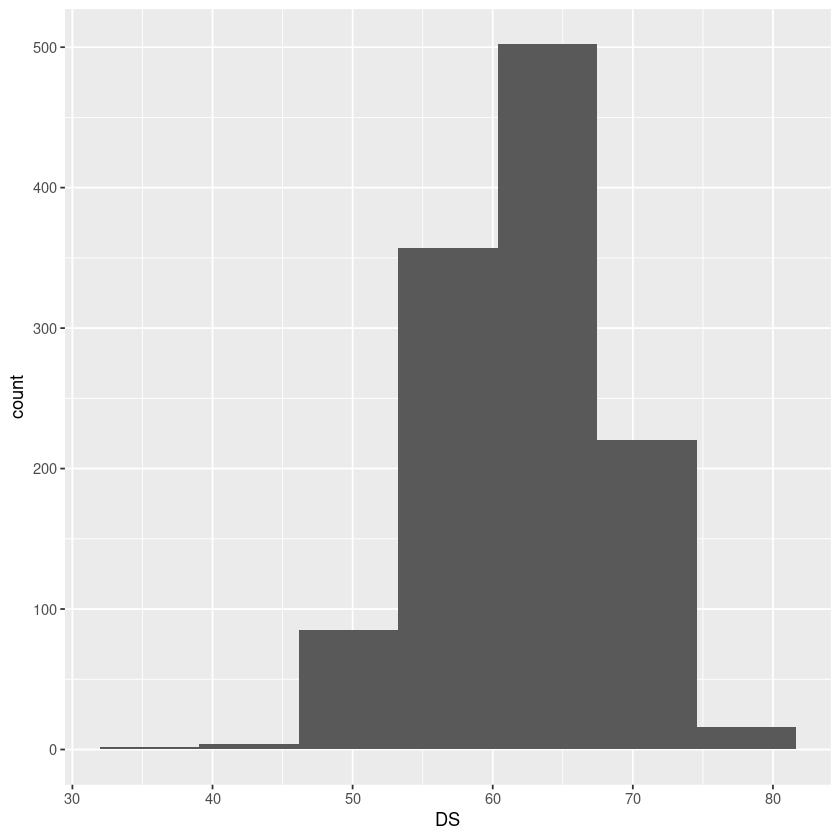

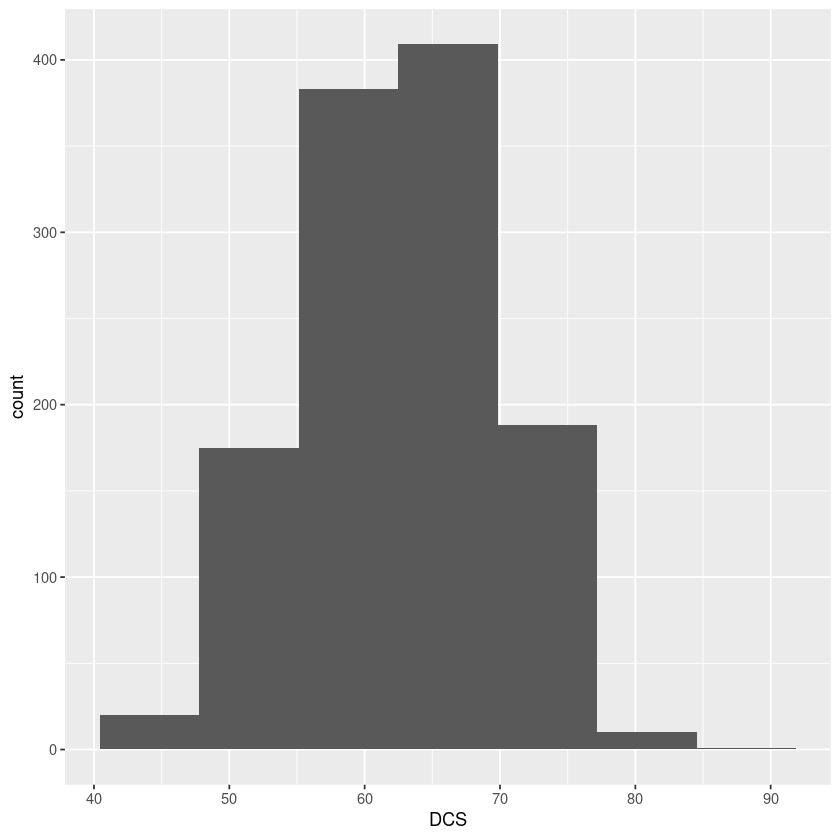

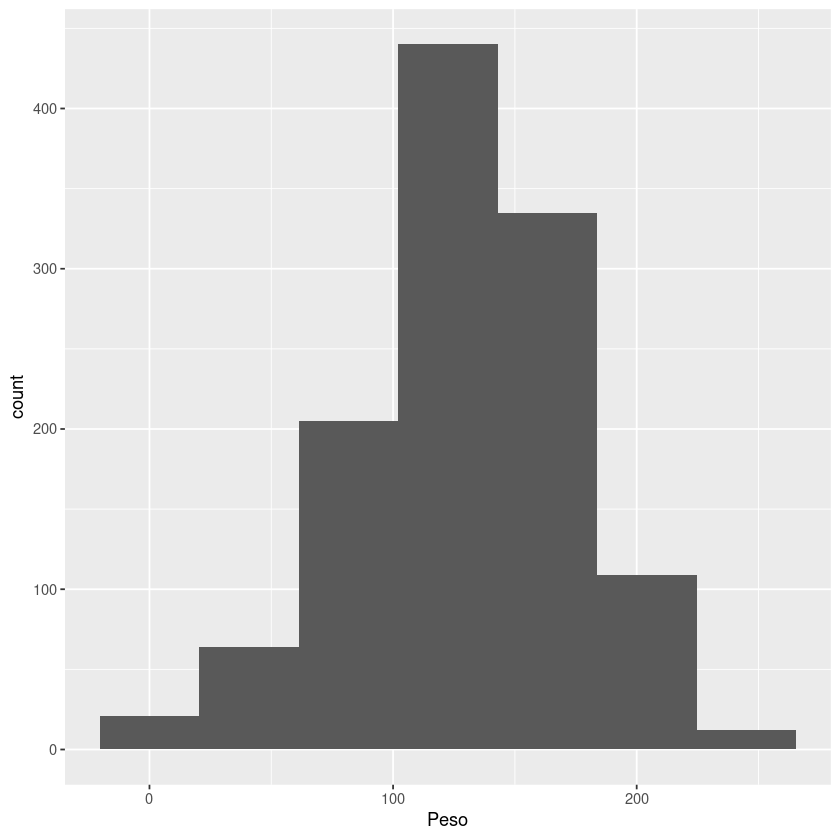

In [5]:
ggplot(data=Data,aes(DS))+
geom_histogram(bins=7)

ggplot(data=Data,aes(DCS))+
geom_histogram(bins=7)

ggplot(data=Data,aes(Peso))+
geom_histogram(bins=7)


In [6]:
str(Data)

spec_tbl_df [1,186 × 5] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ Zona : Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
 $ Finca: Factor w/ 25 levels "101","102","201",..: 4 19 4 4 19 4 19 2 19 4 ...
 $ Peso : num [1:1186] 147 87 139 159 128 83 94 129 105 125 ...
 $ DS   : num [1:1186] 64 57 65 69 64 56 57 63.7 60 63 ...
 $ DCS  : num [1:1186] 67 53 64 67 62 52 55 62.1 59 61 ...
 - attr(*, "spec")=
  .. cols(
  ..   ...1 = col_double(),
  ..   Zona = col_double(),
  ..   Finca = col_double(),
  ..   Peso = col_double(),
  ..   `Diámetro Sutural` = col_double(),
  ..   `Diámetro Contrasutural` = col_double()
  .. )
 - attr(*, "problems")=<externalptr> 


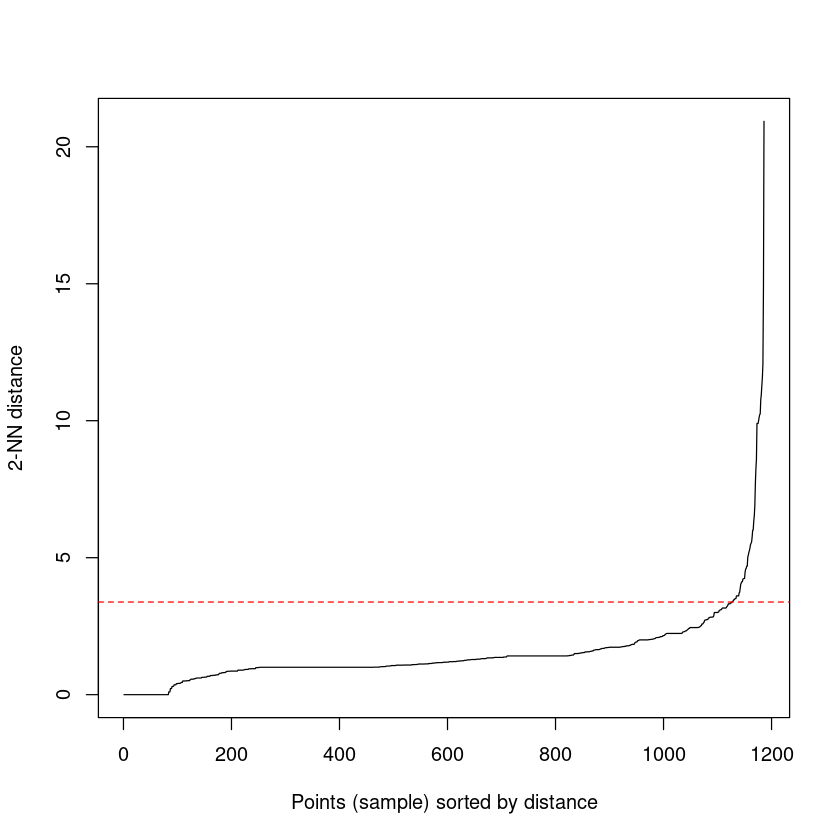

In [7]:
#Looking for outliers
WorkData<- Data %>%dplyr::select(Peso,DS,DCS)
#Choosing eps value
#Calculate distances between transactions using kNN algorithm and aggregate by breaks,
#k=MinPts-1=3-1, MinPts=dimensionality-1
MinPts=3;
k=MinPts-1;
#plot maximum kNN distance distribution, points are ordered in increasing kNN distance.
kNNdistplot(WorkData, k = 2);
eps=quantile(kNNdist(WorkData, k = 2),0.95);
#eps = 0.08
#Select eps value at the curve \"knee\"\
abline(h=eps, col = "red", lty=2);

#Label outliers using DBSCAN algorithm, output$cluster holds the results, 0 indicates \"noise points\" https://cran.r-project.org/web/packages/dbscan/dbscan.pdf\n",
Clusters <- dbscan(WorkData, eps = eps, minPts = 3);

Data<-Data%>%mutate(DBClusters=Clusters$cluster)

 int [1:1186] 1 1 1 1 1 1 1 1 1 1 ...


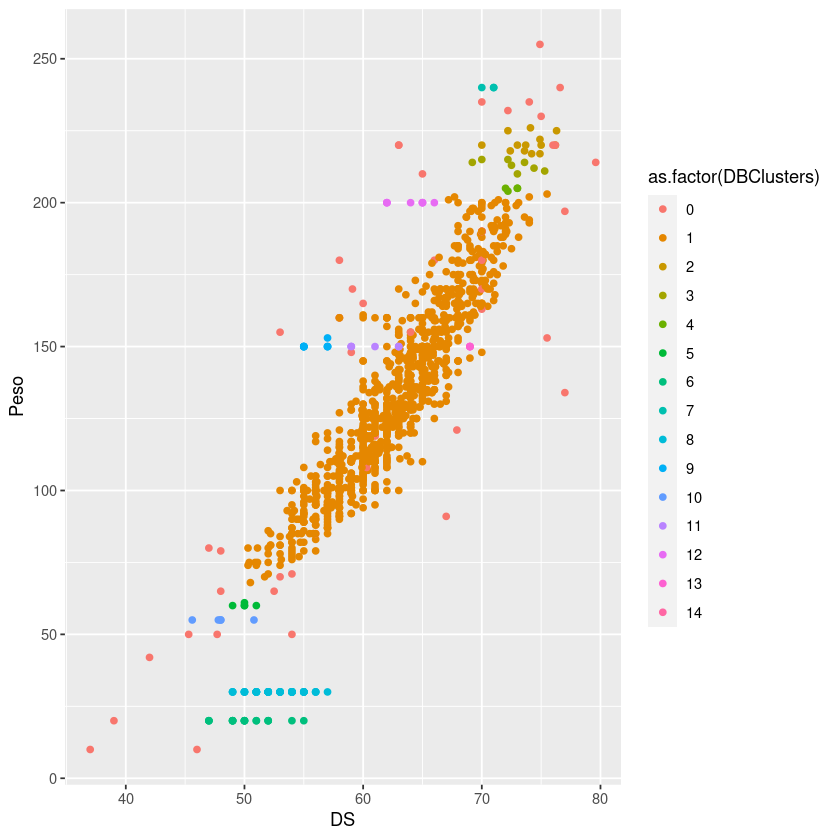

In [8]:
str(Data$DBClusters)

ggplot(data=Data, aes(x=DS,y=Peso,color=as.factor(DBClusters)))+
geom_point();

In [156]:
CleanData<-Data%>%dplyr::filter(DBClusters==1)

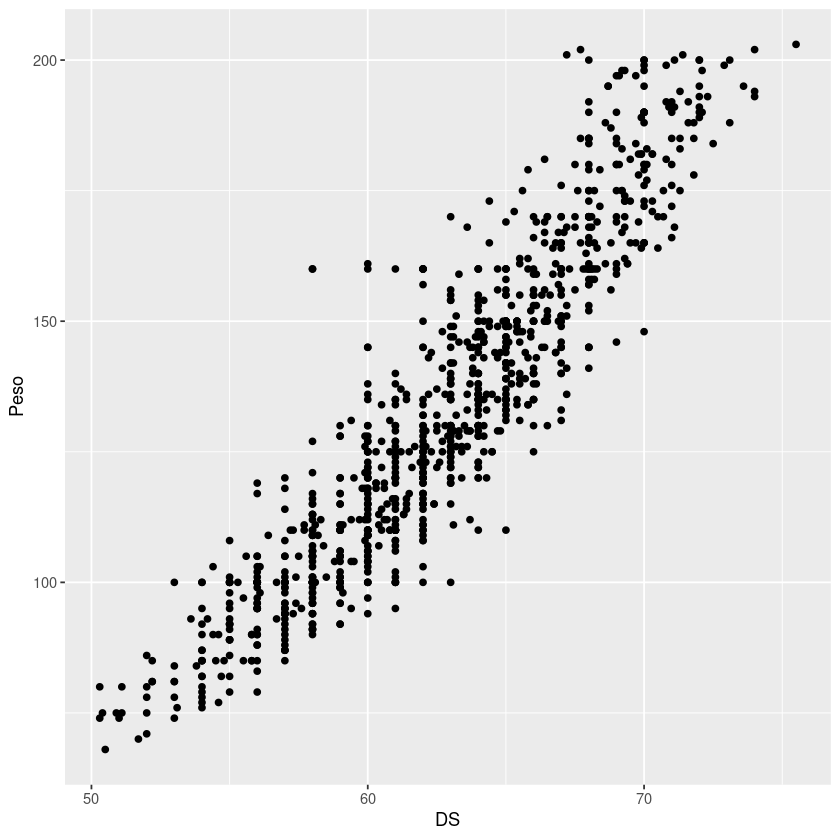

In [157]:
ggplot(data=CleanData,aes(x=DS,y=Peso))+
geom_point()

# Feature selection

In [158]:
#Compressing numerical variables into categorical

print(c("Sturges Classes:",SturgesBins<-round(1+log2(length(CleanData$Zona)),0)))

#"cut" splits data by range, "ntile" splits data by quantiles

#DSBinnedMids<-hist(CleanData$DS,plot=FALSE)$mids
#DCSBinnedMids<-hist(CleanData$DCS,plot=FALSE)$mids

CleanData<-CleanData%>%mutate(
    DSBinned=(cut(CleanData$DS,SturgesBins,labels=FALSE)),
    DCSBinned=(cut(CleanData$DCS,SturgesBins,labels=FALSE))
)

[1] "Sturges Classes:" "11"              


In [159]:
str(CleanData)

tibble [1,004 × 8] (S3: tbl_df/tbl/data.frame)
 $ Zona      : Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
 $ Finca     : Factor w/ 25 levels "101","102","201",..: 4 19 4 4 19 4 19 2 19 4 ...
 $ Peso      : num [1:1004] 147 87 139 159 128 83 94 129 105 125 ...
 $ DS        : num [1:1004] 64 57 65 69 64 56 57 63.7 60 63 ...
 $ DCS       : num [1:1004] 67 53 64 67 62 52 55 62.1 59 61 ...
 $ DBClusters: int [1:1004] 1 1 1 1 1 1 1 1 1 1 ...
 $ DSBinned  : int [1:1004] 6 3 7 9 6 3 3 6 5 6 ...
 $ DCSBinned : int [1:1004] 7 2 6 7 5 2 3 5 4 5 ...


In [160]:
#Since zona and finca are nominal, they are one-hot encoded. 
dummies <- dummyVars(Peso ~ Zona+Finca, data = CleanData)
oneHot<-predict(dummies, newdata = CleanData)
CleanData<-CleanData%>%cbind(as.data.frame(oneHot[,1:3]),as.data.frame(oneHot[,4:28]))

#Moreover, Binned variables are ordinal, therefore they are standarised.
features<-CleanData[,7:8];

preProcValues <- preProcess(features, method = c("center", "scale"))
stdFeatures<-predict(preProcValues, features)
CleanData<-CleanData%>%mutate(DSBinnedNorm=stdFeatures$DSBinned,DCSBinnedNorm=stdFeatures$DCSBinned)

In [161]:
WorkData<-CleanData%>%dplyr::select(Peso,starts_with("Finca."),starts_with("Zona."),ends_with("Norm"))
str(WorkData)

'data.frame':	1004 obs. of  31 variables:
 $ Peso         : num  147 87 139 159 128 83 94 129 105 125 ...
 $ Finca.101    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.102    : num  0 0 0 0 0 0 0 1 0 0 ...
 $ Finca.201    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.301    : num  1 0 1 1 0 1 0 0 0 1 ...
 $ Finca.303    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.401    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.501    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.601    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.701    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.801    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.901    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.902    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1002   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1032   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1101   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1201   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1301   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1401   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1502   : num  0 1 0 0 1 0 1 0 1 0 ...
 

In [162]:
descrCor <-  cor(WorkData%>%dplyr::select(-Peso))
findCorrelation(descrCor, cutoff = .75,verbose=TRUE,names=TRUE)

Compare row 26  and column  28 with corr  0.77 
  Means:  0.212 vs 0.065 so flagging column 26 
Compare row 30  and column  29 with corr  0.886 
  Means:  0.129 vs 0.057 so flagging column 30 
Compare row 27  and column  25 with corr  0.857 
  Means:  0.116 vs 0.053 so flagging column 27 
All correlations <= 0.75 


[1] "Zona.1"        "DCSBinnedNorm" "Zona.2"

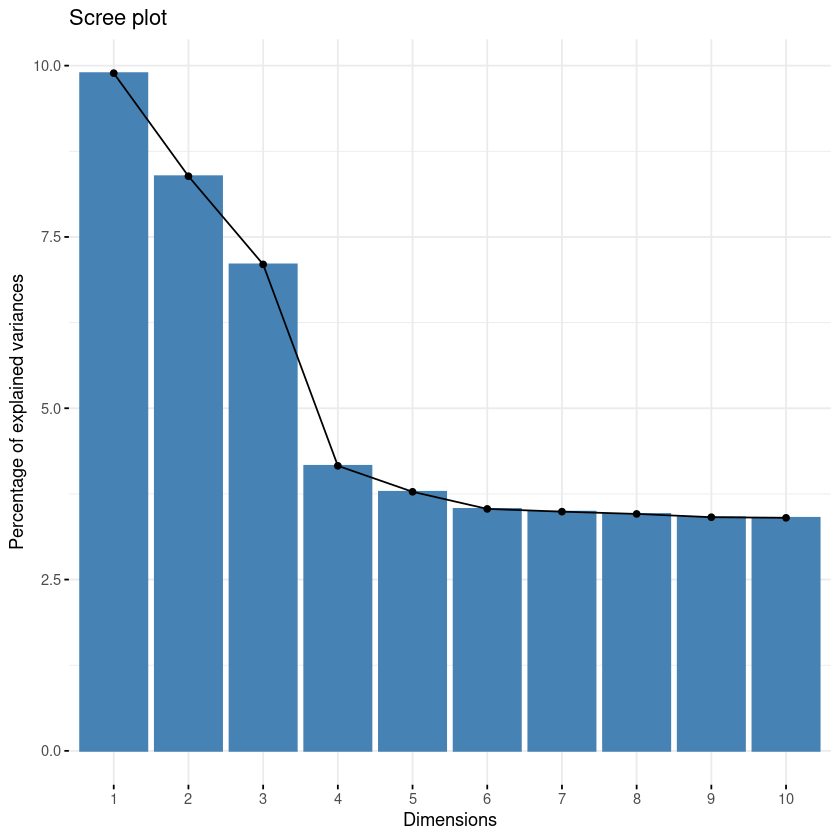

In [163]:
library(factoextra)
res.pca <- prcomp(WorkData%>%dplyr::select(-Peso), scale = TRUE)
fviz_eig(res.pca)

WorkData<-cbind(WorkData,res.pca$x)


#preProcValues <- preProcess(WorkData%>%dplyr::select(-Peso), method = c("pca"))
#PCFeatures<-predict(preProcValues, WorkData%>%dplyr::select(-Peso))
#str(PCFeatures)
#CleanData<-CleanData%>%mutate(DSBinnedNorm=stdFeatures$DSBinned,DCSBinnedNorm=stdFeatures$DCSBinned)

In [164]:
str(WorkData)

'data.frame':	1004 obs. of  61 variables:
 $ Peso         : num  147 87 139 159 128 83 94 129 105 125 ...
 $ Finca.101    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.102    : num  0 0 0 0 0 0 0 1 0 0 ...
 $ Finca.201    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.301    : num  1 0 1 1 0 1 0 0 0 1 ...
 $ Finca.303    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.401    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.501    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.601    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.701    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.801    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.901    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.902    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1002   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1032   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1101   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1201   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1301   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1401   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1502   : num  0 1 0 0 1 0 1 0 1 0 ...
 

Warning message:
“ggrepel: 15 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


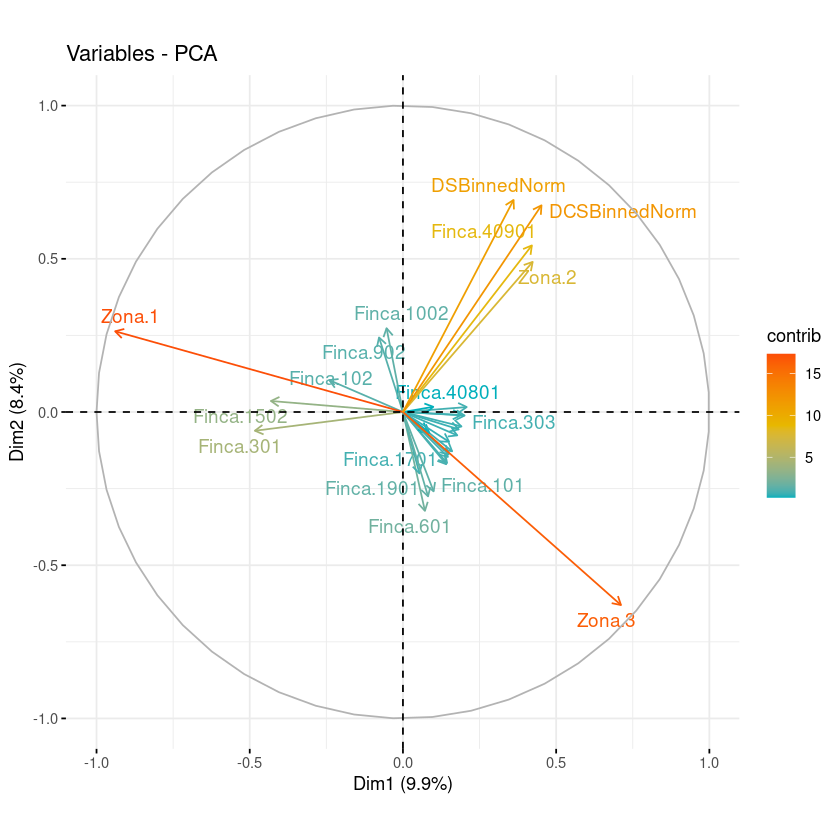

In [165]:
fviz_pca_var(res.pca,
             col.var = "contrib", # Color by contributions to the PC
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE     # Avoid text overlapping
             )

In [166]:
eig.val <- get_eigenvalue(res.pca)
head(eig.val)

,eigenvalue,variance.percent,cumulative.variance.percent
,<dbl>,<dbl>,<dbl>
Dim.1,2.967110,9.890367,9.890367
Dim.2,2.515894,8.386313,18.276680
Dim.3,2.129826,7.099419,25.376100
Dim.4,1.247914,4.159714,29.535814
Dim.5,1.134237,3.780790,33.316604
Dim.6,1.059275,3.530916,36.847520


In [198]:
#Sampling
set.seed(3456)
trainIndex <- createDataPartition(WorkData$Peso, p = .5, 
                                  list = FALSE, 
                                  times = 1)

trainData<-(WorkData%>%dplyr::select(Peso,starts_with("Finca."),ends_with("Norm")))[trainIndex,];

testData<-(WorkData%>%dplyr::select(Peso,starts_with("Finca."),ends_with("Norm")))[-trainIndex,];


Call:
lm(formula = Peso ~ ., data = trainData)

Residuals:
     Min       1Q   Median       3Q      Max 
-28.4489  -4.5502  -0.2623   4.5584  30.7311 

Coefficients: (1 not defined because of singularities)
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   134.1551     1.3382 100.247  < 2e-16 ***
Finca.101      -1.4988     3.0601  -0.490 0.624513    
Finca.102      -3.0468     1.7398  -1.751 0.080545 .  
Finca.201       0.4522     2.8794   0.157 0.875274    
Finca.301      -1.9532     1.5986  -1.222 0.222377    
Finca.303       9.3208     3.8476   2.423 0.015786 *  
Finca.401       3.2005     2.8850   1.109 0.267832    
Finca.501      11.1978     2.8494   3.930 9.76e-05 ***
Finca.601       5.5829     3.1973   1.746 0.081437 .  
Finca.701       3.8496     2.7862   1.382 0.167731    
Finca.801      -8.7974     3.3524  -2.624 0.008964 ** 
Finca.901     -10.8491     2.8752  -3.773 0.000181 ***
Finca.902       1.8912     2.0393   0.927 0.354183    
Finca.1002      4.7299

Warning message in predict.lm(lm0, testData, interval = "prediction", level = 0.95):
“prediction from a rank-deficient fit may be misleading”


[1] "Root Mean Squared Error:" "13.0469669340472"        


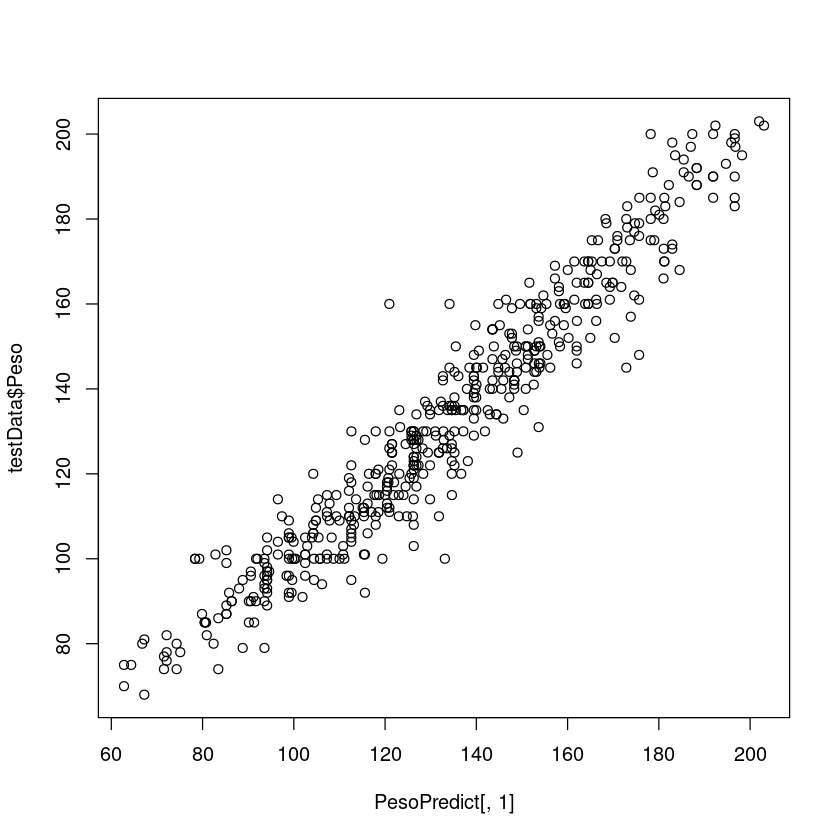

In [199]:
#Baseline model
lm0<-lm(data=trainData,Peso~.)
summary(lm0)

PesoPredict<-predict(lm0,testData,interval="prediction",level=0.95)
RMSE<-sqrt(sum(PesoPredict[,1]^2-testData$Peso^2)/length(testData$Peso))
print(c("Root Mean Squared Error:",RMSE))

In [200]:
train_control <- trainControl(method = "cv",number = 10)

cl <- makeCluster(2)
registerDoParallel(cl)
modelLasso <- train(Peso~.,
                trControl = train_control,
                tuneLength=25,
                data=trainData,
                method="glmnet"               
                );
stopCluster(cl)
modelLasso

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


glmnet 

503 samples
 27 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 453, 454, 453, 453, 452, 453, ... 
Resampling results across tuning parameters:

  alpha   lambda       RMSE       Rsquared   MAE      
  0.1000   0.04811718   8.337701  0.9255682   6.277020
  0.1000   0.06857191   8.337701  0.9255682   6.277020
  0.1000   0.09772202   8.337701  0.9255682   6.277020
  0.1000   0.13926391   8.337701  0.9255682   6.277020
  0.1000   0.19846537   8.337701  0.9255682   6.277020
  0.1000   0.28283353   8.333163  0.9256151   6.277709
  0.1000   0.40306682   8.327382  0.9256832   6.280432
  0.1000   0.57441160   8.322163  0.9257511   6.286202
  0.1000   0.81859550   8.320223  0.9257973   6.299641
  0.1000   1.16658264   8.326563  0.9257914   6.328143
  0.1000   1.66250003   8.348214  0.9257281   6.378490
  0.1000   2.36923323   8.409486  0.9253841   6.463751
  0.1000   3.37640061   8.533278  0.9247865   6.593540
  0.1000   4.81171752   8.76763


Call:  (function (x, y, family = c("gaussian", "binomial", "poisson",      "multinomial", "cox", "mgaussian"), weights = NULL, offset = NULL,      alpha = 1, nlambda = 100, lambda.min.ratio = ifelse(nobs <          nvars, 0.01, 1e-04), lambda = NULL, standardize = TRUE,      intercept = TRUE, thresh = 1e-07, dfmax = nvars + 1, pmax = min(dfmax *          2 + 20, nvars), exclude = NULL, penalty.factor = rep(1,          nvars), lower.limits = -Inf, upper.limits = Inf, maxit = 1e+05,      type.gaussian = ifelse(nvars < 500, "covariance", "naive"),      type.logistic = c("Newton", "modified.Newton"), standardize.response = FALSE,      type.multinomial = c("ungrouped", "grouped"), relax = FALSE,      trace.it = 0, ...)  {     this.call = match.call()     np = dim(x)     if (is.null(np) | (np[2] <= 1))          stop("x should be a matrix with 2 or more columns")     nobs = as.integer(np[1])     nvars = as.integer(np[2])     if (is.null(weights))          weights = rep(1, nobs)     else if (

In [201]:
train_control <- trainControl(method = "cv",number = 10)

trainDataPC<-(WorkData%>%dplyr::select(Peso,starts_with("PC")))[trainIndex,];
testDataPC<-(WorkData%>%dplyr::select(Peso,starts_with("PC")))[-trainIndex,];

cl <- makeCluster(2)
registerDoParallel(cl)
modelPC <- train(Peso~.,
                trControl = train_control,
                tuneLength=25,
                data=trainDataPC,
                method="leapBackward"
                );
stopCluster(cl)
print(modelPC)

Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
“3  linear dependencies found”


Linear Regression with Backwards Selection 

503 samples
 30 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 453, 453, 452, 453, 453, 452, ... 
Resampling results across tuning parameters:

  nvmax  RMSE       Rsquared   MAE      
   2     17.773089  0.6673570  14.916212
   3     11.665601  0.8572025   9.302173
   4      9.122842  0.9127515   7.049078
   5      9.990348  0.8965216   7.351636
   6      9.834950  0.8996142   7.194349
   7      9.834435  0.8994020   7.180534
   8      9.945031  0.8974924   7.229778
   9     14.752948  0.8549246   8.181061
  10     26.531157  0.8407671  10.494287
  11     26.686038  0.8421491  10.502434
  12     27.574421  0.8430339  10.631866
  13     40.534505  0.8427051  13.116538
  14     48.769153  0.8437307  14.696308
  15     48.737091  0.8449418  14.608022
  16     49.606756  0.8447454  14.798169
  17     52.121742  0.8448311  15.247602
  18     47.041273  0.8453565  14.231862
  19     47.011997  0.84648

In [202]:
train_control <- trainControl(method = "cv",number = 10)

cl <- makeCluster(2)
registerDoParallel(cl)
modelPCLasso <- train(Peso~.,
                trControl = train_control,
                tuneLength=25,
                data=trainDataPC,
                method="glmnet"               
                );
stopCluster(cl)
modelPCLasso

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


glmnet 

503 samples
 30 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 452, 453, 453, 453, 453, 453, ... 
Resampling results across tuning parameters:

  alpha   lambda       RMSE       Rsquared   MAE      
  0.1000   0.03321480   8.244656  0.9279781   6.290299
  0.1000   0.04733450   8.244656  0.9279781   6.290299
  0.1000   0.06745652   8.244656  0.9279781   6.290299
  0.1000   0.09613246   8.244656  0.9279781   6.290299
  0.1000   0.13699863   8.244656  0.9279781   6.290299
  0.1000   0.19523711   8.242029  0.9280184   6.292609
  0.1000   0.27823293   8.237560  0.9280914   6.298691
  0.1000   0.39651049   8.234094  0.9281839   6.309723
  0.1000   0.56506816   8.233489  0.9283154   6.326213
  0.1000   0.80528014   8.240768  0.9285033   6.350992
  0.1000   1.14760688   8.271936  0.9286701   6.396138
  0.1000   1.63545763   8.353120  0.9287525   6.479799
  0.1000   2.33069503   8.529051  0.9286028   6.650078
  0.1000   3.32147971   8.87144


Call:  (function (x, y, family = c("gaussian", "binomial", "poisson",      "multinomial", "cox", "mgaussian"), weights = NULL, offset = NULL,      alpha = 1, nlambda = 100, lambda.min.ratio = ifelse(nobs <          nvars, 0.01, 1e-04), lambda = NULL, standardize = TRUE,      intercept = TRUE, thresh = 1e-07, dfmax = nvars + 1, pmax = min(dfmax *          2 + 20, nvars), exclude = NULL, penalty.factor = rep(1,          nvars), lower.limits = -Inf, upper.limits = Inf, maxit = 1e+05,      type.gaussian = ifelse(nvars < 500, "covariance", "naive"),      type.logistic = c("Newton", "modified.Newton"), standardize.response = FALSE,      type.multinomial = c("ungrouped", "grouped"), relax = FALSE,      trace.it = 0, ...)  {     this.call = match.call()     np = dim(x)     if (is.null(np) | (np[2] <= 1))          stop("x should be a matrix with 2 or more columns")     nobs = as.integer(np[1])     nvars = as.integer(np[2])     if (is.null(weights))          weights = rep(1, nobs)     else if (

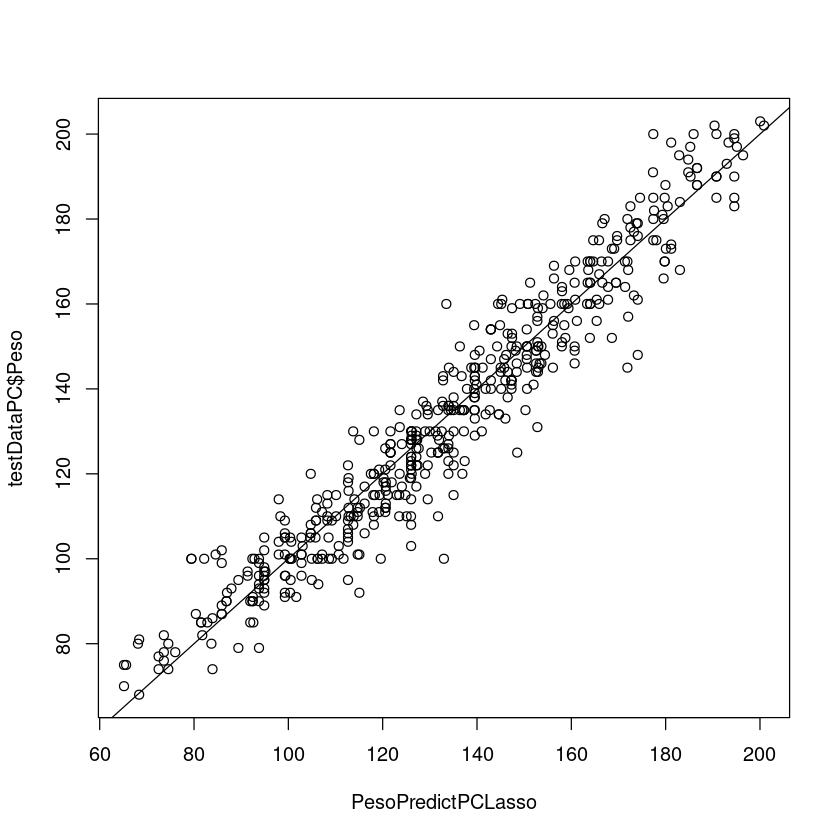

In [205]:
plot(PesoPredictPCLasso,testDataPC$Peso)
abline(0,1)

In [212]:
lm3<-lm(data=CleanData,Peso~I((DCS+DS)/2)^3)
summary(lm3)
PesoPredictLm3<-predict(lm3,CleanData)
summary(PesoPredictLm3)

RMSE<-sqrt(sum((PesoPredictLm3-CleanData$Peso)^2)/length(CleanData$Peso))

print(c("Polynomial Root Mean Squared Error:",RMSE))


Call:
lm(formula = Peso ~ I((DCS + DS)/2)^3, data = CleanData)

Residuals:
    Min      1Q  Median      3Q     Max 
-34.220  -5.244  -0.126   5.177  43.758 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -219.4959     3.3779  -64.98   <2e-16 ***
I((DCS + DS)/2)    5.5956     0.0535  104.60   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.884 on 1002 degrees of freedom
Multiple R-squared:  0.9161,	Adjusted R-squared:  0.916 
F-statistic: 1.094e+04 on 1 and 1002 DF,  p-value: < 2.2e-16


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  61.96  110.65  133.03  132.59  154.15  202.97 

[1] "Polynomial Root Mean Squared Error:" "8.87553995848151"                   


In [216]:
cor(cbind(testData$Peso,PesoPredictLM[,1],PesoPredictLm3,PesoPredictPC,PesoPredictLasso,PesoPredictPCLasso))

Warning message in cbind(testData$Peso, PesoPredictLM[, 1], PesoPredictLm3, PesoPredictPC, :
“number of rows of result is not a multiple of vector length (arg 1)”


,,,PesoPredictLm3,PesoPredictPC,PesoPredictLasso,PesoPredictPCLasso
,1.000000000,0.96350198,-0.004730741,0.95351420,0.96368690,0.96543212
,0.963501977,1.00000000,-0.018015352,0.98979339,0.99985753,0.99926055
PesoPredictLm3,-0.004730741,-0.01801535,1.000000000,-0.01043093,-0.01717876,-0.01659044
PesoPredictPC,0.953514199,0.98979339,-0.010430932,1.00000000,0.99149959,0.99030074
PesoPredictLasso,0.963686902,0.99985753,-0.017178764,0.99149959,1.00000000,0.99927530
PesoPredictPCLasso,0.965432123,0.99926055,-0.016590436,0.99030074,0.99927530,1.00000000


In [217]:
#Random forest

train_control <- trainControl(method = "cv",number = 10)

cl <- makeCluster(2)
registerDoParallel(cl)
modelRF <- train(Peso~.,
                data=testData,
               # preProc=c("center","scale","nzv"),
                trControl = train_control,
                tuneLength=25,
                method="rf"               
                );
stopCluster(cl)
modelRF

Random Forest 

501 samples
 27 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 450, 451, 450, 451, 450, 451, ... 
Resampling results across tuning parameters:

  mtry  RMSE       Rsquared   MAE      
   2    14.510553  0.8535506  11.238789
   3    11.572050  0.8871701   8.971952
   4    10.175583  0.9065030   7.952709
   5     9.433819  0.9161273   7.397411
   6     8.976181  0.9219688   7.022256
   7     8.826560  0.9231459   6.837162
   8     8.712483  0.9243057   6.734731
   9     8.649011  0.9249827   6.666669
  10     8.657625  0.9246323   6.626412
  11     8.636162  0.9246961   6.562182
  12     8.674225  0.9240904   6.592436
  13     8.735434  0.9229569   6.591846
  14     8.745846  0.9227699   6.581117
  15     8.789617  0.9220176   6.603422
  16     8.816583  0.9215218   6.609417
  17     8.870152  0.9205422   6.648094
  18     8.889649  0.9202869   6.653235
  19     8.883369  0.9202628   6.645667
  20     8.946048  0.9190869   6.6

In [219]:
PesoPredictLM<-predict(lm0,testData,interval="prediction",level=0.95)
RMSE<-sqrt(sum((PesoPredict-testData$Peso)^2)/length(testData$Peso))
print(c("Linear Model Root Mean Squared Error:",RMSE))

PesoPredictLasso<-predict(modelLasso,testData)
RMSE<-sqrt(sum((PesoPredictLasso-testData$Peso)^2)/length(testData$Peso))
print(c("Lasso Root Mean Squared Error:",RMSE))

PesoPredictPC<-predict(modelPC,testDataPC)
RMSE<-sqrt(sum((PesoPredictPC-testDataPC$Peso)^2)/length(testDataPC$Peso))
print(c("Principal Components Linear Model Root Mean Squared Error:",RMSE))


PesoPredictPCLasso<-predict(modelPCLasso,testDataPC)
RMSE<-sqrt(sum((PesoPredictPCLasso-testDataPC$Peso)^2)/length(testDataPC$Peso))
print(c("PC Lasso Root Mean Squared Error:",RMSE))

PesoPredictRF<-predict(modelRF,testData)
RMSE<-sqrt(sum((PesoPredictRF-testData$Peso)^2)/length(testData$Peso))
print(c("Random forest Root Mean Squared Error:",RMSE))

Warning message in predict.lm(lm0, testData, interval = "prediction", level = 0.95):
“prediction from a rank-deficient fit may be misleading”


[1] "Linear Model Root Mean Squared Error:"
[2] "27.2344361964273"                     
[1] "Lasso Root Mean Squared Error:" "8.27169277996113"              
[1] "Principal Components Linear Model Root Mean Squared Error:"
[2] "9.34624744635613"                                          
[1] "PC Lasso Root Mean Squared Error:" "8.0522519591647"                  
[1] "Random forest Root Mean Squared Error:"
[2] "6.06998032922897"                      
